# Horns Rev Wind Farm Notebook

![](http://news.vattenfall.com/sites/default/files/styles/article_hero_image/public/NEW_Horns%20rev%20wind%20farm%2006_hero.jpg)

Vestas 80m diameter turbines with 70m hub

Arranged in grid of 8x10

## References
http://orbit.dtu.dk/files/69840567/Evaluation_of_the_Wind_Direction.pdf

# Initialise

In [1]:
# Create EPIC client
#from zutil.plot import *
import numpy as np
import math
import matplotlib
import os
import pandas as pd

#  This is required when running in script mode
batch = False
if 'BATCH_ANALYSIS' in os.environ:
    batch = True

from matplotlib.rcsetup import all_backends

if batch:
    if 'Agg' in all_backends:
        matplotlib.use('Agg')
    else:
        matplotlib.use('agg')
else:
    if 'nbagg' in all_backends:
        matplotlib.use('nbagg')
    else:
        matplotlib.use('nbAgg')

matplotlib.rcParams['backend_fallback'] = False

from matplotlib import pylab, mlab, pyplot
plt = pyplot
if batch:
    plt.ioff()
else:
    plt.ion()

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs

class font:
    font_size = 12
    axis_font_size = 12
    axis_tick_font_size = 12
    legend_font = 8
    title_font_size = 16

ft = font

class colour:
    zeno_orange = '#E58B1C'
    zeno_grey = '#5D5858'
   
cl = colour

def get_figure(plt, x=8, y=5):
    return plt.figure(figsize=(x, y), dpi=100, facecolor='w', edgecolor=cl.zeno_orange)


def x_label(ax, text):
    ax.set_xlabel(text, fontsize=ft.axis_font_size,
                  fontweight='bold', color=cl.zeno_grey)


def y_label(ax, text):
    ax.set_ylabel(text, fontsize=ft.axis_font_size,
                  fontweight='bold', color=cl.zeno_grey)


def set_title(ax, text):
    ax.set_title(text, fontsize=ft.title_font_size)


def set_suptitle(fig, text):
    fig.suptitle(text, fontsize=24, fontweight='normal', color=cl.zeno_grey)


def set_legend(ax, location, label_list=None):
    if label_list is not None:
        legend = ax.legend(loc=location, scatterpoints=1, numpoints=1, shadow=False,
                           fontsize=ft.legend_font, labels=label_list)
    else:
        legend = ax.legend(loc=location, scatterpoints=1, numpoints=1, shadow=False,
                           fontsize=ft.legend_font)
    legend.get_frame().set_facecolor('white')
    return legend


def set_ticks(ax):

    ax.tick_params(axis='x')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(ft.axis_tick_font_size)
        tick.label.set_fontweight('normal')
        tick.label.set_color(cl.zeno_orange)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(ft.axis_tick_font_size)
        tick.label.set_fontweight('normal')
        tick.label.set_color(cl.zeno_orange)

import os
from pyepic.core import EpicClient
# Choose SWEPT2 team
os.environ['EPIC_TEAM'] = '31'
# Create client
client = EpicClient(epic_url="https://epic.zenotech.com", epic_token="")

ModuleNotFoundError: No module named 'pyepic'

In [2]:
# Login to EPIC
from ipywidgets import widgets
from IPython.display import display

container = widgets.Box()
username = widgets.Text(description="Username:")
#password = widgets.Password(description="Password:")
login_btn = widgets.Button(description="Login")
#container.children = [username, password, login_btn]

def login(sender):
    global epic_token
    print('Username: %s' % (username.value))
   #client.EPIC_TOKEN = client.get_security_token(username.value, password.value)
    client.EPIC_TOKEN = client.get_security_token("s.longbottom@warwick.ac.uk","Blackbelt2310")
    container.close()
    
login_btn.on_click(login)
#password.on_submit(login)

display(container)

# Define wind directions

In [3]:
# Define wind directions
#from zutil import farm as farm
#from zutil import analysis

def vector_from_wind_dir(wind_dir_degree, wind_speed=1.0):
    """
    Return vector given a wind direction and wind speed
    Wind dir = 0.0 -> [0.0,-1.0,0.0]
    Wind dir = 90.0 -> [-1.0,0.0,0.0]
    Wind dir - Meteorological wind direction
    (direction from which wind is blowing)
    u -> Zone Velocity (Towards East)
    v -> Meridional Velocity (Towards North)
    """

    return [-wind_speed * math.sin(math.radians(wind_dir_degree)),
            -wind_speed * math.cos(math.radians(wind_dir_degree)),
            0.0]

class farm:
    @staticmethod
    def get_case_name(base_case, wind_direction, wind_speed):
        wind_direction_str = '{0:.2f}'.format(wind_direction).replace('.', 'p')
        wind_speed_str = '{0:.2f}'.format(wind_speed).replace('.', 'p')
        return base_case + '_' + wind_direction_str + '_' + wind_speed_str
    @staticmethod
    def get_profile_name(base_case, wind_direction, wind_speed):
        wind_direction_str = '{0:.2f}'.format(wind_direction).replace('.', 'p')
        wind_speed_str = '{0:.2f}'.format(wind_speed).replace('.', 'p')
        return 'profile_' + wind_direction_str + '_' + wind_speed_str


wind_speed = 8.1982323
wind_speed = 8.0
wind_speed_at_height = 70.0
#directions = [258, 264, 270, 276, 282]
directions = []
for a in range(254,287,1):
    directions.append(a)
roughness_length = 0.0002

location_file_name = 'xy_V80b_D0_cp.txt'
turbine_def = 'V80b_D0.trbx'

epic_location = 'HornsRev/othermesh_1mnexttoground'
epic_location = 'HornsRev'

# Data Location
#analysis.data_init('/gpfs/projects/swept2/workarea/JA/HORNSREV')
#analysis.data_init('/gpfs/projects/swept2/workarea/ARCHER/HORNSREV')

case_idx = 0
case_name = farm.get_case_name('hornsrev',directions[case_idx],wind_speed)
profile_name = farm.get_profile_name('hornsrev',directions[case_idx],wind_speed)


# Wind Farm Power

In [1]:
# Read turbine locations 'xy_V80b_D0.txt'
import numpy as np
import matplotlib.cm as cmx
import matplotlib.colors as colors
from ipywidgets import interact, fixed
from ipywidgets import widgets
from ipywidgets import interactive
import io

#from zutil import vector_from_wind_dir

# Plot MW
power_scaling = 1000000.0

#print 'location file name = ' + location_file_name
location_array = np.genfromtxt(location_file_name, dtype=None)
# catch the case where only one turbine location is specified
if (location_array.ndim < 1):
    location_array = np.reshape(location_array,(1,))
       
N = len(location_array)
easting = np.zeros(N)    
northing = np.zeros(N)
power = np.zeros(N)
name = []
idx = 0
for location in location_array:
    name.append(location[0])
    easting[idx] = location[1]
    northing[idx] = location[2]    
    idx = idx + 1
        
power_results = {}
# Get power
for direc in directions:
    case_name = farm.get_case_name('hornsrev',direc,wind_speed)
    case_location = epic_location+'/'+case_name
    file_data = io.BytesIO()
    power_results[case_name] = np.zeros_like(power)
    try:
        client.download_fileobj(case_location+'/'+case_name+'_report.csv',file_data)
        data = pd.read_csv(io.StringIO(file_data.getvalue().decode("utf-8")),sep=' ')
        idx = 0
        for location in location_array:
            power_results[case_name][idx] = data[location[0]+'_power'].iloc[-1]
            idx = idx + 1
    except:
        pass
        
# Get a colour map                
cmap = plt.get_cmap('rainbow') 
cNorm  = colors.Normalize(vmin=200000/power_scaling, vmax=850000/power_scaling)
#cNorm  = colors.Normalize(vmin=np.amin(power), vmax=np.amax(power))

# Draw a figure    
fig = get_figure(plt,12,8)

def plot_figure(case_idx):

    fig.clf()
    
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    scalarMap._A = []

    total_power = np.sum(power/power_scaling)
    
    ax = fig.add_subplot(111)
    ax.grid(True)
    set_title(ax,'Horns Rev Turbine Power Output - '+str(directions[case_idx]) + ' - '+'{0:.2f} MW'.format(total_power))
    ax.set_xlim(423000,430000)
    ax.set_ylim(6146000,6153000)
    ax.set_aspect('equal')
    x_label(ax,'Easting')
    y_label(ax,'Northing')
    set_ticks(ax)
    
    scatter = ax.scatter(easting,northing, s=power/800.0, c=scalarMap.to_rgba(power/power_scaling), alpha=1.0)

    fig.colorbar(scalarMap, orientation="vertical", pad=0.2, label='Power (MW)')
    
    for i, txt in enumerate(name):
        ax.annotate(txt, (easting[i],northing[i]))
        
    draw_arrow(case_idx,ax)

def draw_arrow(case_idx,ax):
    wind_vec = np.asarray(vector_from_wind_dir(directions[case_idx],1.0)[:2])
    xy=np.asarray([424000, 6148750])
    xytext = xy - wind_vec*1500.0

    ax.annotate(directions[case_idx], xy=xy, xytext=xytext,
                arrowprops=dict(facecolor='black', shrink=0.05),
                )

def get_power(case_idx):
    case_name = farm.get_case_name('hornsrev',directions[case_idx],wind_speed)
    """
    r = Report()
    r.read_data(analysis.data.data_dir+'/'+case_name+'_report.csv')
    idx = 0
    for location in location_array:
        power[idx] = r.data[location[0]+'_power'].iloc[-1]
        idx = idx + 1
    """
    global power
    power = power_results[case_name]

def update_power(frame):
    get_power(frame)
    plot_figure(frame)

# Draw slider
myinteract = interact(update_power,frame=widgets.IntSlider(description='Direction',min=0,max=len(directions)-1,step=1,value=0),
                     continuous_update=False)



NameError: name 'location_file_name' is not defined

# Turbine Row Power Output

xy_V80b_D0_cp.txt


<IPython.core.display.Javascript object>


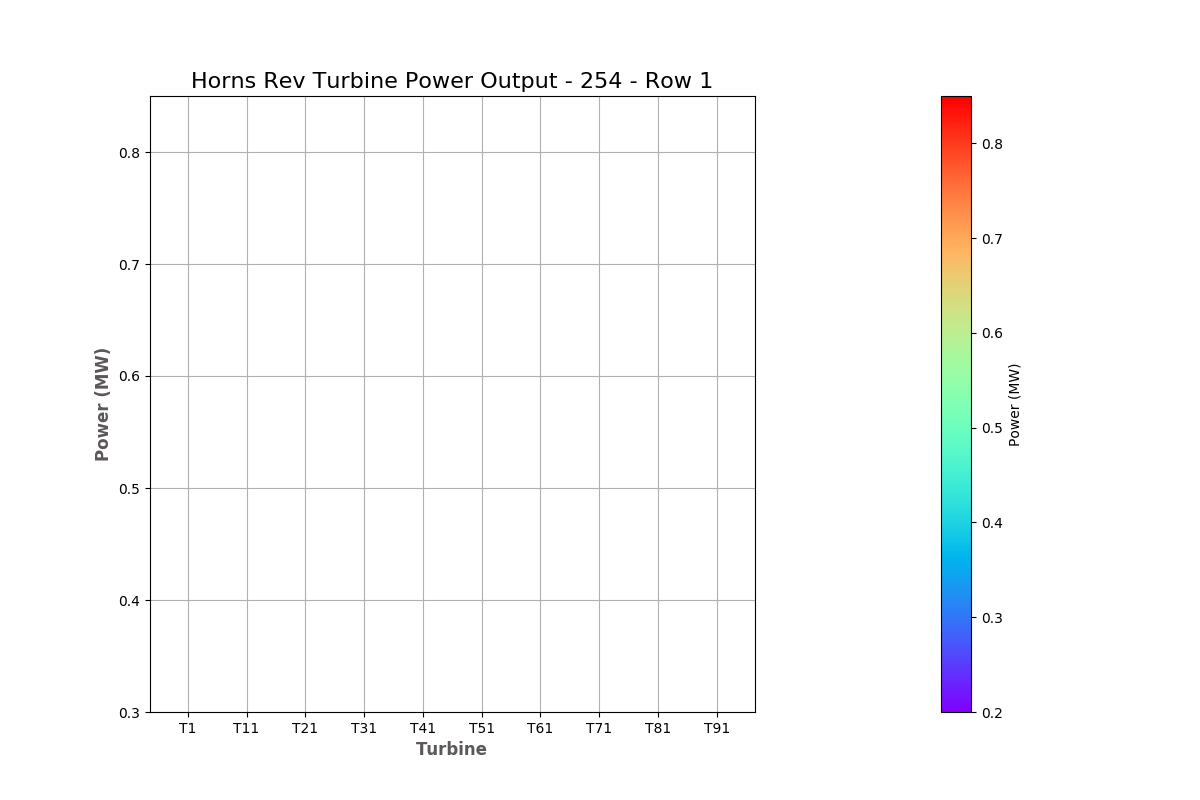

In [5]:
# Read turbine locations 'xy_V80b_D0.txt'
import matplotlib.cm as cmx
import matplotlib.colors as colors
from ipywidgets import interact, fixed
from ipywidgets import widgets
from ipywidgets import interactive

#from zutil import vector_from_wind_dir

# Plot MW
power_scaling = 1000000.0

#print 'location file name = ' + location_file_name
location_array = np.genfromtxt(location_file_name, dtype=None)

print location_file_name

# catch the case where only one turbine location is specified
if (location_array.ndim < 1):
    location_array = np.reshape(location_array,(1,))
       
N = len(location_array)
easting = np.zeros(N)    
northing = np.zeros(N)
power = np.zeros(N)
name = []
idx = 0
for location in location_array:
    name.append(location[0])
    easting[idx] = location[1]
    northing[idx] = location[2]    
    idx = idx + 1
        
        
name_array = np.asarray(name).reshape(10,8)
# Get a colour map                
cmap = plt.get_cmap('rainbow') 
cNorm  = colors.Normalize(vmin=200000/power_scaling, vmax=850000/power_scaling)
#cNorm  = colors.Normalize(vmin=np.amin(power), vmax=np.amax(power))

# Draw a figure    
fig = get_figure(plt,12,8)

def plot_figure(row,power, case_idx, switch_row_col):

    fig.clf()
    
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    scalarMap._A = []
    
    ax = fig.add_subplot(111)
    ax.grid(True)
    if switch_row_col:
        set_title(ax,'Horns Rev Turbine Power Output - '+str(directions[case_idx]) + ' - Col '+str(row+1))
        data_array = power[row]
    else:
        set_title(ax,'Horns Rev Turbine Power Output - '+str(directions[case_idx]) + ' - Row '+str(row+1))
        data_array = power[:,row]
    
    data_array = data_array/power_scaling
        
    ax.set_ylim(300000/power_scaling,850000/power_scaling)
    x_label(ax,'Turbine')
    y_label(ax, 'Power (MW)')
    
    ind = np.arange(len(data_array))  # the x locations for the groups
    width = 0.35       # the width of the bars

    ax.set_xticks(ind + width)
    if switch_row_col:
        ax.set_xticklabels(name_array[row])
    else:
        ax.set_xticklabels(name_array[:,row])
    
    ax.bar(ind+width,data_array, width, color=scalarMap.to_rgba(data_array))
    
    fig.colorbar(scalarMap, orientation="vertical", pad=0.2, label='Power (MW)')


def get_row_power(case_idx):
    case_name = farm.get_case_name('hornsrev',directions[case_idx],wind_speed)
    """
    r = Report()
    r.read_data(case_name+'_report.csv')
    idx = 0
    power = np.zeros(N)
    for location in location_array:
        power[idx] = r.data[location[0]+'_power'].iloc[-1]
        idx = idx + 1
    power = power.reshape(10,8)
    """
    return power_results[case_name].reshape(10,8)

        
def update_row_power(row, case_idx, switch):
    power = get_row_power(case_idx)
    if not switch:
        row = min(row,8)
    plot_figure(row-1,power,case_idx, switch)

    
row_widget=widgets.IntSlider(description='Row/Col',min=1,max=8,step=1,value=0)
switch_widget=widgets.Checkbox(value=False, description='Flip ')

def update_row_range(*args):
    if switch_widget.value:
        row_widget.max = 10
    else:
        row_widget.max = 8
switch_widget.observe(update_row_range, 'value')

# Draw slider
myinteract = interact(update_row_power,row=row_widget,
                      case_idx=widgets.IntSlider(description='Direction',min=0,max=len(directions)-1,step=1,value=0),
                      switch=switch_widget,
                      continuous_update=False)



# Turbine Power Ratio vs SCADA

In [6]:
# Read turbine locations 'xy_V80b_D0.txt'
import matplotlib.cm as cmx
import matplotlib.colors as colors
from ipywidgets import interact, fixed
from ipywidgets import widgets
from ipywidgets import interactive
import scipy.stats as stats

from zutil import vector_from_wind_dir

# Plot MW
power_scaling = 1000000.0

#print 'location file name = ' + location_file_name
location_array = np.genfromtxt(location_file_name, dtype=None)
# catch the case where only one turbine location is specified
if (location_array.ndim < 1):
    location_array = np.reshape(location_array,(1,))
       
N = len(location_array)
easting = np.zeros(N)    
northing = np.zeros(N)
power = np.zeros(N)
name = []
idx = 0
for location in location_array:
    name.append(location[0])
    easting[idx] = location[1]
    northing[idx] = location[2]    
    idx = idx + 1
        
        
name_array = np.asarray(name).reshape(10,8)
# Get a colour map                
cmap = plt.get_cmap('rainbow') 
cNorm  = colors.Normalize(vmin=200000/power_scaling, vmax=850000/power_scaling)
#cNorm  = colors.Normalize(vmin=np.amin(power), vmax=np.amax(power))

# Draw a figure    
fig = get_figure(plt,12,8)

ref_data_narrow = np.asarray([1,1.0026,0.1378,1,
2,0.6766,0.1576,0.4473,
3,0.6658,0.147,0.3903,
4,0.6352,0.1506,0.3742,
5,0.622,0.1594,0.3668,
6,0.6035,0.1461,0.3628,
7,0.5931,0.1479,0.3607,
8,0.571,0.1386,0.3593,
9,0.5553,0.1384,0.3584,
10,0.5411,0.1464,0.358]).reshape(10,4)

ref_data_wide = np.asarray([1, 1.0074, 0.1463, 1,
2, 0.8064, 0.207, 0.7718,
3, 0.7992, 0.2076, 0.7571,
4, 0.7668, 0.2059, 0.747,
5, 0.7342, 0.1983, 0.7141,
6, 0.7029, 0.1822, 0.6974,
7, 0.6781, 0.1771, 0.6905,
8, 0.6483, 0.1699, 0.686,
9, .6312, 0.1695, 0.6829,
10, 0.617, 0.1863, 0.6809]).reshape(10,4)


def plot_figure(row,power, case_idx, sector_width):

    fig.clf()
    
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    scalarMap._A = []
    
    sector_delta = 0.0
    if case_idx-sector_width >= 0 and case_idx+sector_width < len(directions):
        sector_delta = directions[case_idx] - directions[case_idx-sector_width]
    
    ax = fig.add_subplot(111)
    ax.grid(True)
    if sector_width == 0:
        set_title(ax,'Horns Rev Turbine Power Ratio - '+str(directions[case_idx]) + ' - Row '+str(row+1))
    else:
        set_title(ax,r'Horns Rev Turbine Power Ratio Sector Average - '+str(directions[case_idx]) + '$\pm$' +str(sector_delta) + ' - Row '+str(row+1))
        
    # Get row data
    data_array = power[:,row]
    # Scale to MW
    data_array = data_array/power_scaling
    # Scale by first turbine in row
    data_array = data_array/data_array[0]
    
    ax.set_ylim(0.0,1.0)
    x_label(ax,'Turbine')
    y_label(ax, 'Power Ratio')
    
    ind = np.arange(len(data_array))  # the x locations for the groups
    width = 0.35       # the width of the bars

    ax.set_xticks(ind + width)
    ax.set_xticklabels(name_array[:,row])
    
    ax.bar(ind+width,data_array, width, color=scalarMap.to_rgba(data_array))
    #print ref_data[:,1]
    (_, caps, _) = ax.errorbar(ind+width,ref_data_narrow[:,1],yerr=ref_data_narrow[:,2],label='SCADA Narrow Range',capsize=4,elinewidth=2)
    for cap in caps:
        cap.set_markeredgewidth(2)
        
    (_, caps, _) = ax.errorbar(ind+width,ref_data_wide[:,1],yerr=ref_data_wide[:,2],label='SCADA Wide Range',capsize=4,elinewidth=2)
    for cap in caps:
        cap.set_markeredgewidth(2)
    #ax.plot(ind+width,ref_data_narrow[:,3],label='Jenson Model Narrow')
    #ax.plot(ind+width,ref_data_wide[:,3],label='Jenson Model Wide')
    
    set_legend(ax,'best')

    fig.colorbar(scalarMap, orientation="vertical", pad=0.2, label='Power Ratio')

def get_row_power(case_idx, switch, sector_width, sigma):
    
    if not switch or case_idx < sector_width or case_idx > len(directions)-sector_width:
        case_name = farm.get_case_name('hornsrev',directions[case_idx],wind_speed)
        """
        r = Report()
        r.read_data(analysis.data.data_dir+'/'+case_name+'_report.csv')
        idx = 0
        power = np.zeros(N)
        for location in location_array:
            power[idx] = r.data[location[0]+'_power'].iloc[-1]
            idx = idx + 1
        power = power.reshape(10,8)
        """
        return power_results[case_name].reshape(10,8)
    else:
        # Compute sector average
        power = np.zeros(N)
        
        # Normal distribution with specifed mean and sigma
        norm = stats.norm(directions[case_idx],sigma)
        sum_of_weight = 0.0
        # Loop over sectors
        for c in range(case_idx-sector_width,case_idx+sector_width+1):
            case_name = farm.get_case_name('hornsrev',directions[c],wind_speed)
            """
            r = Report()
            r.read_data(analysis.data.data_dir+'/'+case_name+'_report.csv')
            idx = 0
            weight = norm.pdf(directions[c])
            for location in location_array:
                power[idx] +=  weight * r.data[location[0]+'_power'].iloc[-1]
                idx += 1    
            sum_of_weight += weight
            """
            weight = norm.pdf(directions[c])
            power = power_results[case_name]
            sum_of_weight += weight
        # Average
        power = power.reshape(10,8)/sum_of_weight  
        return power
        
def update_row_power(row, case_idx, switch, sector_width, sigma):
    power = get_row_power(case_idx, switch, sector_width,sigma)
    plot_figure(row-1,power,case_idx, sector_width)

# Create widgets
row_widget=widgets.IntSlider(description='Row/Col',min=1,max=8,step=1,value=0)
switch_widget=widgets.Checkbox(value=False, description='Sector Average ')

# Draw widgets
myinteract = interact(update_row_power,row=row_widget,
                      case_idx=widgets.IntSlider(description='Direction',min=0,max=len(directions)-1,step=1,value=0),
                      sector_width=widgets.IntSlider(description='Sector Width',min=0,max=(len(directions)-1)/2,step=1,value=0),
                      switch=switch_widget,
                      sigma=widgets.FloatSlider(description='Sigma',min=0,max=10.0,value=2.67),
                      continuous_update=False)



/Users/longbottom/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in divide
/Users/longbottom/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


<IPython.core.display.Javascript object>


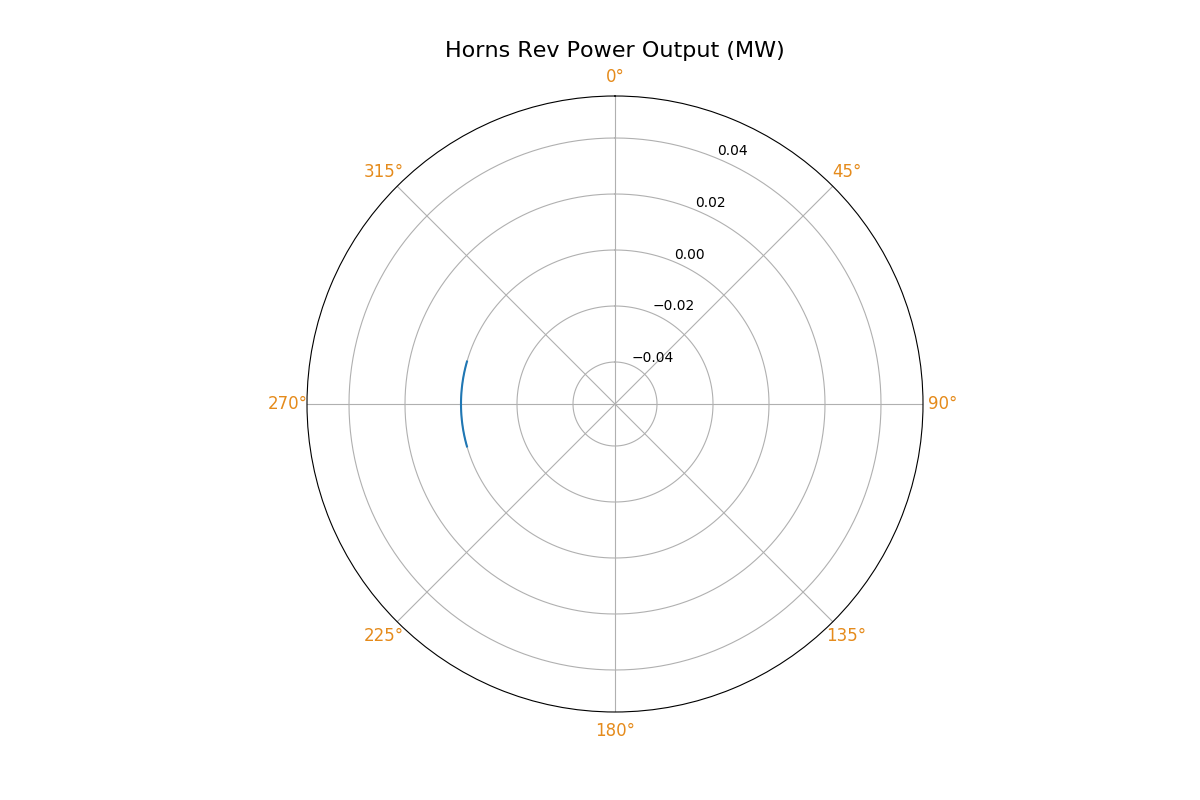

In [7]:
# Power output per wind direction
import matplotlib.cm as cmx
import matplotlib.colors as colors
from ipywidgets import interact, fixed
from ipywidgets import widgets
from ipywidgets import interactive

#from zutil import vector_from_wind_dir

# Plot MW
power_scaling = 1000000.0

#print 'location file name = ' + location_file_name
location_array = np.genfromtxt(location_file_name, dtype=None)
# catch the case where only one turbine location is specified
if (location_array.ndim < 1):
    location_array = np.reshape(location_array,(1,))
    
       
N = len(location_array)
easting = np.zeros(N)    
northing = np.zeros(N)
power = np.zeros(N)
name = []
idx = 0
for location in location_array:
    name.append(location[0])
    easting[idx] = location[1]
    northing[idx] = location[2]    
    idx = idx + 1

def get_total_power(case_idx):
    case_name = farm.get_case_name('hornsrev',directions[case_idx],wind_speed)
    """
    r = Report()
    r.read_data(analysis.data.data_dir+'/'+case_name+'_report.csv')
    idx = 0
    power = np.zeros(N)
    for location in location_array:
        power[idx] = r.data[location[0]+'_power'].iloc[-1]
        idx = idx + 1
    """
    power = power_results[case_name]
    return np.sum(power)
    
    
# Get a colour map                
cmap = plt.get_cmap('rainbow') 
cNorm  = colors.Normalize(vmin=200000/power_scaling, vmax=850000/power_scaling)
#cNorm  = colors.Normalize(vmin=np.amin(power), vmax=np.amax(power))

# Draw a figure    
fig = get_figure(plt,12,8)
    
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = []

total_power = np.zeros(len(directions))
for i,d in enumerate(directions):
    total_power[i] = get_total_power(i)
    
direc_array = np.asarray(directions)

ax = fig.add_subplot(111, projection='polar')
ax.grid(True)
set_title(ax,'Horns Rev Power Output (MW)')
set_ticks(ax)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
p = ax.plot(np.deg2rad(directions),total_power/power_scaling)
